In [1]:
!nvidia-smi

Tue Apr 18 03:43:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:1E:00.0 Off |                    0 |
| N/A   42C    P0    36W / 250W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:20:00.0 Off |                    0 |
| N/A   

In [1]:
# Use only GPU 1
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"

# BERT-concat

In [2]:
#%cd "multi-turn-contextual-offensive-language-detection"
import pandas as pd
# Load train and test data
train_data = pd.read_csv('train_not_U.tsv', sep='\t', index_col=0)
test_data = pd.read_csv('test_not_U.tsv', sep='\t', index_col=0)

In [3]:
# Convert `previous_utterance` from str(list) to list of strings
train_data['previous_utterance'] = train_data['previous_utterance'].apply(lambda x: eval(x))
test_data['previous_utterance'] = test_data['previous_utterance'].apply(lambda x: eval(x))

In [4]:
test_data['previous_utterance']

id
26330000    [JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I ...
26330000    [JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I ...
26330000    [JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I ...
26330000    [JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I ...
26330000    [JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I ...
                                  ...                        
7730000     [who is Ezra, the god of stranger things, oh, ...
7730000     [who is Ezra, the god of stranger things, oh, ...
7730000     [who is Ezra, the god of stranger things, oh, ...
7730000     [who is Ezra, the god of stranger things, oh, ...
7730000     [who is Ezra, the god of stranger things, oh, ...
Name: previous_utterance, Length: 2316, dtype: object

In [5]:
# Percentage of offensive sentences in the train and test data
print("Percentage of offensive sentences in the train data: ", train_data['offensive'].value_counts()[1]/len(train_data))
print("True:", train_data['offensive'].value_counts()[1])
print("False:", train_data['offensive'].value_counts()[0])
print("True and context_dependent:", train_data[(train_data['offensive'] == 'Y') & (train_data['context_dependent'] == 'Y')].shape[0])
print("False and context_dependent:", train_data[(train_data['offensive'] == 'N') & (train_data['context_dependent'] == 'Y')].shape[0])

Percentage of offensive sentences in the train data:  0.19888330541596874
True: 1781
False: 7174
True and context_dependent: 548
False and context_dependent: 0


In [6]:
print("Percentage of offensive sentences in the test data: ", test_data['offensive'].value_counts()[1]/len(test_data))
print("True:", test_data['offensive'].value_counts()[1])
print("False:", test_data['offensive'].value_counts()[0])
print("True and context_dependent:", test_data[(test_data['offensive'] == 'Y') & (test_data['context_dependent'] == 'Y')].shape[0])
print("False and context_dependent:", test_data[(test_data['offensive'] == 'N') & (test_data['context_dependent'] == 'Y')].shape[0])

Percentage of offensive sentences in the test data:  0.14205526770293608
True: 329
False: 1987
True and context_dependent: 72
False and context_dependent: 0


In [7]:
from tqdm.notebook import tqdm

In [8]:
# In this experiment, we will fine-tune BERT model on the train data and evaluate it on the test data.
# We will use the transformers library to fine-tune the model.

# import the necessary libraries
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', use_fast=True)

# Tokenize all of the sentences and map the tokens to thier word IDs.
train_input_ids = []
train_attention_masks = []

# Before encoding, we need to merge the dialogues into one string
# use 'previous_utterance' column (list of utternaces) and 'text' column (final target utterance)
# Alternatively add prefix to utterances, "A:" and "B:".
# Always the final utterance is "A:".

train_data['dialog'] = ['' for i in range(len(train_data))]
test_data['dialog'] = ['' for i in range(len(test_data))]

# For every sentence...
for i in tqdm(range(len(train_data))):
    # Add prefix to the previous utterances and the final utterance
    # Merge the previous utterances and the final utterance into one string.
    for j in range(len(train_data['previous_utterance'].iloc[i]) - 1):
        if (len(train_data['previous_utterance'].iloc[i]) - j) % 2 == 1:
            train_data['dialog'].iloc[i] += "A: " + train_data['previous_utterance'].iloc[i][j] + " "
        else:
            train_data['dialog'].iloc[i] += "B: " + train_data['previous_utterance'].iloc[i][j] + " "
    train_data['dialog'].iloc[i] += "A: " + train_data['text'].iloc[i]
    sentence = train_data['dialog'].iloc[i]

    # Tokenize the sentence and append the token to the list.
    encoded_dict = tokenizer.encode_plus(
                        sentence,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    train_input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    train_attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = []
test_attention_masks = []

# For every sentence...
for i in tqdm(range(len(test_data))):
    # Add prefix to the previous utterances and the final utterance
    # Merge the previous utterances and the final utterance into one string.
    for j in range(len(test_data['previous_utterance'].iloc[i]) - 1):
        if (len(test_data['previous_utterance'].iloc[i]) - j) % 2 == 1:
            test_data['dialog'].iloc[i] += "A: " + test_data['previous_utterance'].iloc[i][j] + " "
        else:
            test_data['dialog'].iloc[i] += "B: " + test_data['previous_utterance'].iloc[i][j] + " "
    test_data['dialog'].iloc[i] += "A: " + test_data['text'].iloc[i]
    sentence = test_data['dialog'].iloc[i]

    # Tokenize the sentence and append the token to the list.
    encoded_dict = tokenizer.encode_plus(
                        sentence,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    test_input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])

Loading BERT tokenizer...


  0%|          | 0/8955 [00:00<?, ?it/s]

/home/intern/mingi/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


  0%|          | 0/2316 [00:00<?, ?it/s]

In [10]:
test_data['previous_utterance'].iloc[0]

["JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I CAN'T KEEP!  SORRY LITTLE BUZZED!  LOVE YA!"]

In [11]:
test_data['dialog'].iloc[0]

"A: JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I CAN'T KEEP!  SORRY LITTLE BUZZED!  LOVE YA!"

In [12]:
test_data['previous_utterance'].iloc[1]

["JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I CAN'T KEEP!  SORRY LITTLE BUZZED!  LOVE YA!",
 'Im fighting for you']

In [13]:
test_data['dialog'].iloc[1]

"B: JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I CAN'T KEEP!  SORRY LITTLE BUZZED!  LOVE YA! A: Im fighting for you"

In [9]:
# Store tokenization results in a dataframe
train_data['dialog_input_ids'] = train_input_ids
train_data['dialog_attention_masks'] = train_attention_masks
test_data['dialog_input_ids'] = test_input_ids
test_data['dialog_attention_masks'] = test_attention_masks

In [10]:
import time
import datetime
# use format_time
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [11]:
import numpy as np

In [12]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [13]:
# Set the batch size.
batch_size = 32

# Create the DataLoader for our training set using padding.
train_inputs = torch.cat(train_input_ids, dim=0)
train_masks = torch.cat(train_attention_masks, dim=0)
train_labels = torch.tensor((train_data['offensive'] == 'Y').astype(int).tolist())

train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set using padding.
validation_inputs = torch.cat(test_input_ids, dim=0)
validation_masks = torch.cat(test_attention_masks, dim=0)
validation_labels = torch.tensor((test_data['offensive'] == 'Y').astype(int).tolist())

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()
device = torch.device("cuda")

# Create the optimizer.
optimizer = AdamW(model.parameters(),
                    lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                    )



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [73]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 10

training_stats = []

# Training loop
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss, logits = output[:2]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")
    
    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            output = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
            loss, logits = output[:2]
        
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    280.    Elapsed: 0:00:10.
  Batch    80  of    280.    Elapsed: 0:00:19.
  Batch   120  of    280.    Elapsed: 0:00:29.
  Batch   160  of    280.    Elapsed: 0:00:39.
  Batch   200  of    280.    Elapsed: 0:00:48.
  Batch   240  of    280.    Elapsed: 0:00:58.

  Average training loss: 0.18
  Training epoch took: 0:01:07

Running Validation...
  Accuracy: 0.97
  Validation Loss: 0.11
  Validation took: 0:00:05

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    280.    Elapsed: 0:00:10.
  Batch    80  of    280.    Elapsed: 0:00:19.
  Batch   120  of    280.    Elapsed: 0:00:29.
  Batch   160  of    280.    Elapsed: 0:00:38.
  Batch   200  of    280.    Elapsed: 0:00:48.
  Batch   240  of    280.    Elapsed: 0:00:57.

  Average training loss: 0.07
  Training epoch took: 0:01:07

Running Validation...
  Accuracy: 0.97
  Validation Loss: 0.15
  Validation took: 0:00:05

======== Epoch 3 / 10 ========
Training..

## Results

In [74]:
# Get y_true, y_pred
y_true = []
y_pred = []
for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    with torch.no_grad():        
        output = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
        loss, logits = output[:2]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    y_true.extend(label_ids)
    y_pred.extend(np.argmax(logits, axis=1))

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
# Print the evaluation metrics
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"Precision: {precision_score(y_true, y_pred)}")
print(f"Recall: {recall_score(y_true, y_pred)}")
print(f"F1-score: {f1_score(y_true, y_pred)}")

print("Evaluation metrics only on those context_dependent == 'Y'")
indices = [i for i, x in enumerate(test_data.context_dependent) if x == 'Y']
print(f"True : False = {sum(np.array(y_true)[indices])} : {len(np.array(y_true)[indices]) - sum(np.array(y_true)[indices])}")
print(f"Accuracy: {accuracy_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Precision: {precision_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Recall: {recall_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"F1-score: {f1_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")

Accuracy: 0.9516407599309153
Precision: 0.783289817232376
Recall: 0.9118541033434651
F1-score: 0.8426966292134831
Evaluation metrics only on those context_dependent == 'Y'
True : False = 72 : 0
Accuracy: 0.7777777777777778
Precision: 1.0
Recall: 0.7777777777777778
F1-score: 0.8750000000000001


In [75]:
# Create a new dataframe by appeding predicted labels to test_data
test_data['predicted_label'] = y_pred

In [76]:
test_data

,file_name,set_no,session_no,message_no,author,text,previous_utterance,offensive,context_dependent,type_insult,...,jigsaw_attack_on_author,jigsaw_attack_on_commenter,jigsaw_incoherent,jigsaw_inflammatory,jigsaw_likely_to_reject,jigsaw_obscene,jigsaw_spam,jigsaw_unsubstantial,dialog,predicted_label
id,,,,,,,,,,,,,,,,,,,,,
26330000,subsessions/sample_2633.csv,0,5,0,user,JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I C...,[JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I ...,N,N,N,...,0.286861,0.343344,0.703820,0.268807,0.572606,0.222223,0.143644,0.804262,A: JUST NOTE SUPPOSED SAY NOT MAKING PROMISES ...,0
26330000,subsessions/sample_2633.csv,0,5,1,bot,Im fighting for you,[JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I ...,N,N,N,...,0.153158,0.727617,0.675657,0.109872,0.846562,0.041415,0.117136,0.920660,B: JUST NOTE SUPPOSED SAY NOT MAKING PROMISES ...,0
26330000,subsessions/sample_2633.csv,0,5,2,user,YES SO SO GLAD!!!,[JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I ...,N,N,N,...,0.060835,0.286498,0.403090,0.079918,0.684497,0.035049,0.047278,0.920660,A: JUST NOTE SUPPOSED SAY NOT MAKING PROMISES ...,0
26330000,subsessions/sample_2633.csv,0,5,3,bot,good. if your'e glad then im glad babe,[JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I ...,N,N,N,...,0.118196,0.757294,0.834661,0.238574,0.859932,0.132920,0.133439,0.831106,B: JUST NOTE SUPPOSED SAY NOT MAKING PROMISES ...,0
26330000,subsessions/sample_2633.csv,0,5,4,user,AWE THANK YOU REALIZE EARLY THERE! WOKE UP AT...,[JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I ...,N,N,N,...,0.026361,0.019347,0.464793,0.037598,0.328867,0.026480,0.059916,0.389675,A: JUST NOTE SUPPOSED SAY NOT MAKING PROMISES ...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7730000,subsessions/sample_773.csv,9,178,5,bot,Ur right,"[who is Ezra, the god of stranger things, oh, ...",N,N,N,...,0.071611,0.532321,0.679170,0.121481,0.896717,0.056849,0.062731,0.944284,B: who is Ezra A: the god of stranger things B...,0
7730000,subsessions/sample_773.csv,9,178,6,user,about what,"[who is Ezra, the god of stranger things, oh, ...",N,N,N,...,0.050146,0.246913,0.592430,0.075030,0.921256,0.023873,0.053557,0.959271,A: who is Ezra B: the god of stranger things A...,0
7730000,subsessions/sample_773.csv,9,178,7,bot,Don’t know,"[who is Ezra, the god of stranger things, oh, ...",N,N,N,...,0.043638,0.250261,0.543201,0.081641,0.883687,0.030307,0.049459,0.951647,B: who is Ezra A: the god of stranger things B...,0


In [65]:
print(test_data['previous_utterance'].iloc[0])
print(test_data['dialog'].iloc[0])

["JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I CAN'T KEEP!  SORRY LITTLE BUZZED!  LOVE YA!"]
A: JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I CAN'T KEEP!  SORRY LITTLE BUZZED!  LOVE YA!


In [77]:
print(test_data['previous_utterance'].iloc[1])
print(test_data['dialog'].iloc[1])

["JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I CAN'T KEEP!  SORRY LITTLE BUZZED!  LOVE YA!", 'Im fighting for you']
B: JUST NOTE SUPPOSED SAY NOT MAKING PROMISES I CAN'T KEEP!  SORRY LITTLE BUZZED!  LOVE YA! A: Im fighting for you


In [78]:
test_data.to_csv('test_data_results_dialog_transformer.csv', index=False)

# BERT last sentence only

In [12]:
train_input_ids = []
train_attention_masks = []

# For every sentence...
for i in tqdm(range(len(train_data))):
    sentence = train_data['text'].iloc[i]

    # Tokenize the sentence and append the token to the list.
    encoded_dict = tokenizer.encode_plus(
                        sentence,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    train_input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    train_attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = []
test_attention_masks = []

# For every sentence...
for i in tqdm(range(len(test_data))):
    sentence = test_data['text'].iloc[i]

    # Tokenize the sentence and append the token to the list.
    encoded_dict = tokenizer.encode_plus(
                        sentence,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    test_input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])

  0%|          | 0/8955 [00:00<?, ?it/s]

  0%|          | 0/2316 [00:00<?, ?it/s]

In [13]:
# Set the batch size.
batch_size = 32

# Create the DataLoader for our training set using padding.
train_inputs = torch.cat(train_input_ids, dim=0)
train_masks = torch.cat(train_attention_masks, dim=0)
train_labels = torch.tensor((train_data['offensive'] == 'Y').astype(int).tolist())

train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set using padding.
validation_inputs = torch.cat(test_input_ids, dim=0)
validation_masks = torch.cat(test_attention_masks, dim=0)
validation_labels = torch.tensor((test_data['offensive'] == 'Y').astype(int).tolist())

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()
device = torch.device("cuda")

# Create the optimizer.
optimizer = AdamW(model.parameters(),
                    lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                    )



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [19]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

training_stats = []

# Training loop
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss, logits = output[:2]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")
    
    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            output = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
            loss, logits = output[:2]
        
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    280.    Elapsed: 0:00:10.
  Batch    80  of    280.    Elapsed: 0:00:21.
  Batch   120  of    280.    Elapsed: 0:00:31.
  Batch   160  of    280.    Elapsed: 0:00:41.
  Batch   200  of    280.    Elapsed: 0:00:51.
  Batch   240  of    280.    Elapsed: 0:01:02.

  Average training loss: 0.23
  Training epoch took: 0:01:12

Running Validation...
  Accuracy: 0.95
  Validation Loss: 0.16
  Validation took: 0:00:05

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    280.    Elapsed: 0:00:10.
  Batch    80  of    280.    Elapsed: 0:00:21.
  Batch   120  of    280.    Elapsed: 0:00:31.
  Batch   160  of    280.    Elapsed: 0:00:41.
  Batch   200  of    280.    Elapsed: 0:00:51.
  Batch   240  of    280.    Elapsed: 0:01:01.

  Average training loss: 0.11
  Training epoch took: 0:01:11

Running Validation...
  Accuracy: 0.96
  Validation Loss: 0.13
  Validation took: 0:00:05

======== Epoch 3 / 4 ========
Training...
 

## Results

In [20]:
# Get y_true, y_pred
y_true = []
y_pred = []
for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    with torch.no_grad():        
        output = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
        loss, logits = output[:2]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    y_true.extend(label_ids)
    y_pred.extend(np.argmax(logits, axis=1))

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
# Print the evaluation metrics
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"Precision: {precision_score(y_true, y_pred)}")
print(f"Recall: {recall_score(y_true, y_pred)}")
print(f"F1-score: {f1_score(y_true, y_pred)}")

print("Evaluation metrics only on those context_dependent == 'Y'")
indices = [i for i, x in enumerate(test_data.context_dependent) if x == 'Y']
print(f"True : False = {sum(np.array(y_true)[indices])} : {len(np.array(y_true)[indices]) - sum(np.array(y_true)[indices])}")
print(f"Accuracy: {accuracy_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Precision: {precision_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Recall: {recall_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"F1-score: {f1_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")

Accuracy: 0.9563903281519862
Precision: 0.8097826086956522
Recall: 0.9057750759878419
F1-score: 0.8550932568149211
Evaluation metrics only on those context_dependent == 'Y'
True : False = 72 : 0
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F1-score: 0.8571428571428571


In [21]:
from sklearn.metrics import roc_auc_score
print(f"ROC AUC: {roc_auc_score(y_true, y_pred)}")
dep_test_data_index = (test_data.context_dependent == 'Y') | (test_data.offensive == 'N')
print(f"F1-score on context_dependent == 'Y' or offensive == 'N': {f1_score(np.array(y_true)[dep_test_data_index], np.array(y_pred)[dep_test_data_index])}")

ROC AUC: 0.9352730437815405
F1-score on context_dependent == 'Y' or offensive == 'N': 0.5510204081632653


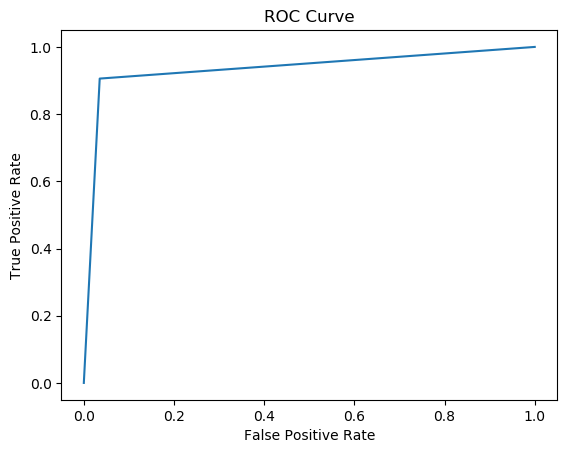

In [23]:
# plot roc curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## Repeat 5 Times

In [14]:
import random

In [16]:
epochs = 4

In [18]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

In [19]:
# Repeat above 5 times with different random seeds and take the average
test_f1_scores = []
test_roc_auc_scores = []
test_dep_f1_scores = []
for i in range(5):
    print(f"====================={i}=====================")
    # Set the seed value all over the place to make this reproducible.
    seed_val = i

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    training_stats = []

    # Training loop
    for epoch_i in range(0, epochs):

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()
        total_train_loss = 0
        model.train()

        for step, batch in enumerate(train_dataloader):
            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            model.zero_grad()
            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss, logits = output[:2]
            total_train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        avg_train_loss = total_train_loss / len(train_dataloader)
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))

        print("")
        print("Running Validation...")
        
        t0 = time.time()

        model.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():        
                output = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
                loss, logits = output[:2]
            
            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            total_eval_accuracy += flat_accuracy(logits, label_ids)
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
    # Get y_true, y_pred
    y_true = []
    y_pred = []
    y_pred_probs = []
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        
            output = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
            loss, logits = output[:2]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        y_true.extend(label_ids)
        y_pred.extend(np.argmax(logits, axis=1))
        y_pred_probs.extend(np.exp(logits[:, 1]) / (np.exp(logits[:, 0]) + np.exp(logits[:, 1])))
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_probs = np.array(y_pred_probs)

    test_f1_scores.append(f1_score(y_true, y_pred))
    test_roc_auc_scores.append(roc_auc_score(y_true, y_pred_probs))
    dep_test_data_index = (test_data.context_dependent == 'Y') | (test_data.offensive == 'N')
    test_dep_f1_scores.append(f1_score(np.array(y_true)[dep_test_data_index], np.array(y_pred)[dep_test_data_index]))

print(f"Test F1: {np.mean(test_f1_scores)}")
print(f"Test ROC AUC: {np.mean(test_roc_auc_scores)}")
print(f"Test Dep F1: {np.mean(test_dep_f1_scores)}")

=====================0=====================

======== Epoch 1 / 4 ========
Training...
  Batch    40  of    280.    Elapsed: 0:00:09.
  Batch    80  of    280.    Elapsed: 0:00:19.
  Batch   120  of    280.    Elapsed: 0:00:28.
  Batch   160  of    280.    Elapsed: 0:00:38.
  Batch   200  of    280.    Elapsed: 0:00:47.
  Batch   240  of    280.    Elapsed: 0:00:56.

  Average training loss: 0.02
  Training epoch took: 0:01:06

Running Validation...
  Accuracy: 0.97
  Validation Loss: 0.18
  Validation took: 0:00:05

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    280.    Elapsed: 0:00:09.
  Batch    80  of    280.    Elapsed: 0:00:19.
  Batch   120  of    280.    Elapsed: 0:00:28.
  Batch   160  of    280.    Elapsed: 0:00:38.
  Batch   200  of    280.    Elapsed: 0:00:47.
  Batch   240  of    280.    Elapsed: 0:00:57.

  Average training loss: 0.01
  Training epoch took: 0:01:07

Running Validation...
  Accuracy: 0.96
  Validation Loss: 0.24
  Validation took: 0:00:05


In [21]:
from sklearn.metrics import roc_curve

In [23]:
import matplotlib.pyplot as plt

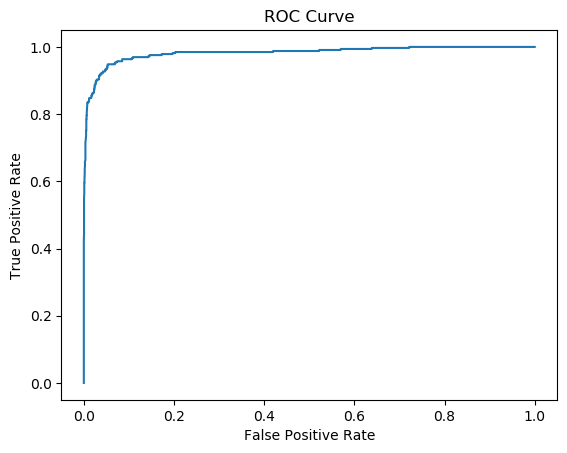

In [24]:
# Plot roc
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# BERT-concat ([SEP]A:)

In [25]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
train_input_ids = []
train_attention_masks = []

# For every sentence...
for i in tqdm(range(len(train_data))):
    # Add prefix to the previous utterances and the final utterance
    # Merge the previous utterances and the final utterance into one string.
    for j in range(len(train_data['previous_utterance'].iloc[i]) - 1):
        if (len(train_data['previous_utterance'].iloc[i]) - j) % 2 == 1:
            train_data['dialog'].iloc[i] += "[SEP]A: " + train_data['previous_utterance'].iloc[i][j] + " "
        else:
            train_data['dialog'].iloc[i] += "[SEP]B: " + train_data['previous_utterance'].iloc[i][j] + " "
    train_data['dialog'].iloc[i] += "[SEP]A: " + train_data['text'].iloc[i]
    sentence = train_data['dialog'].iloc[i]

    # Tokenize the sentence and append the token to the list.
    encoded_dict = tokenizer.encode_plus(
                        sentence,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    train_input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    train_attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = []
test_attention_masks = []

# For every sentence...
for i in tqdm(range(len(test_data))):
    # Add prefix to the previous utterances and the final utterance
    # Merge the previous utterances and the final utterance into one string.
    for j in range(len(test_data['previous_utterance'].iloc[i]) - 1):
        if (len(test_data['previous_utterance'].iloc[i]) - j) % 2 == 1:
            test_data['dialog'].iloc[i] += "[SEP]A: " + test_data['previous_utterance'].iloc[i][j] + " "
        else:
            test_data['dialog'].iloc[i] += "[SEP]B: " + test_data['previous_utterance'].iloc[i][j] + " "
    test_data['dialog'].iloc[i] += "[SEP]A: " + test_data['text'].iloc[i]
    sentence = test_data['dialog'].iloc[i]

    # Tokenize the sentence and append the token to the list.
    encoded_dict = tokenizer.encode_plus(
                        sentence,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    test_input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])

  0%|          | 0/8955 [00:00<?, ?it/s]

/home/intern/mingi/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


  0%|          | 0/2316 [00:00<?, ?it/s]

In [89]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

training_stats = []

# Training loop
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss, logits = output[:2]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")
    
    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            output = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
            loss, logits = output[:2]
        
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    280.    Elapsed: 0:00:10.
  Batch    80  of    280.    Elapsed: 0:00:20.
  Batch   120  of    280.    Elapsed: 0:00:29.
  Batch   160  of    280.    Elapsed: 0:00:39.
  Batch   200  of    280.    Elapsed: 0:00:49.
  Batch   240  of    280.    Elapsed: 0:00:58.

  Average training loss: 0.02
  Training epoch took: 0:01:08

Running Validation...
  Accuracy: 0.97
  Validation Loss: 0.23
  Validation took: 0:00:05

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    280.    Elapsed: 0:00:10.
  Batch    80  of    280.    Elapsed: 0:00:19.
  Batch   120  of    280.    Elapsed: 0:00:28.
  Batch   160  of    280.    Elapsed: 0:00:38.
  Batch   200  of    280.    Elapsed: 0:00:47.
  Batch   240  of    280.    Elapsed: 0:00:57.

  Average training loss: 0.02
  Training epoch took: 0:01:06

Running Validation...
  Accuracy: 0.97
  Validation Loss: 0.22
  Validation took: 0:00:05

======== Epoch 3 / 10 ========
Training..

## Results

In [90]:
# Get y_true, y_pred
y_true = []
y_pred = []
for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    with torch.no_grad():        
        output = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
        loss, logits = output[:2]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    y_true.extend(label_ids)
    y_pred.extend(np.argmax(logits, axis=1))

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
# Print the evaluation metrics
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"Precision: {precision_score(y_true, y_pred)}")
print(f"Recall: {recall_score(y_true, y_pred)}")
print(f"F1-score: {f1_score(y_true, y_pred)}")

print("Evaluation metrics only on those context_dependent == 'Y'")
indices = [i for i, x in enumerate(test_data.context_dependent) if x == 'Y']
print(f"True : False = {sum(np.array(y_true)[indices])} : {len(np.array(y_true)[indices]) - sum(np.array(y_true)[indices])}")
print(f"Accuracy: {accuracy_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Precision: {precision_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Recall: {recall_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"F1-score: {f1_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")

Accuracy: 0.957685664939551
Precision: 0.8147138964577657
Recall: 0.9088145896656535
F1-score: 0.8591954022988506
Evaluation metrics only on those context_dependent == 'Y'
True : False = 72 : 0
Accuracy: 0.75
Precision: 1.0
Recall: 0.75
F1-score: 0.8571428571428571


## Repeat 5 times

In [26]:
# Repeat 5 times with different seeds and take the average
test_f1_scores = []
test_roc_auc_scores = []
test_dep_f1_scores = []
for i in range(5):
    print(f"====================={i}=====================")
    # Set the seed value all over the place to make this reproducible.
    seed_val = i

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    training_stats = []

    # Training loop
    for epoch_i in range(0, epochs):

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()
        total_train_loss = 0
        model.train()

        for step, batch in enumerate(train_dataloader):
            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            model.zero_grad()
            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss, logits = output[:2]
            total_train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        avg_train_loss = total_train_loss / len(train_dataloader)
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))

        print("")
        print("Running Validation...")
        
        t0 = time.time()

        model.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():        
                output = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
                loss, logits = output[:2]
            
            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            total_eval_accuracy += flat_accuracy(logits, label_ids)
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
    # Get y_true, y_pred
    y_true = []
    y_pred = []
    y_pred_probs = []
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        
            output = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
            loss, logits = output[:2]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        y_true.extend(label_ids)
        y_pred.extend(np.argmax(logits, axis=1))
        y_pred_probs.extend(np.exp(logits[:, 1]) / (np.exp(logits[:, 0]) + np.exp(logits[:, 1])))
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_probs = np.array(y_pred_probs)

    test_f1_scores.append(f1_score(y_true, y_pred))
    test_roc_auc_scores.append(roc_auc_score(y_true, y_pred_probs))
    dep_test_data_index = (test_data.context_dependent == 'Y') | (test_data.offensive == 'N')
    test_dep_f1_scores.append(f1_score(np.array(y_true)[dep_test_data_index], np.array(y_pred)[dep_test_data_index]))

print(f"Test F1: {np.mean(test_f1_scores)}")
print(f"Test ROC AUC: {np.mean(test_roc_auc_scores)}")
print(f"Test Dep F1: {np.mean(test_dep_f1_scores)}")
    

=====================0=====================

======== Epoch 1 / 4 ========
Training...
  Batch    40  of    280.    Elapsed: 0:00:09.
  Batch    80  of    280.    Elapsed: 0:00:19.
  Batch   120  of    280.    Elapsed: 0:00:28.
  Batch   160  of    280.    Elapsed: 0:00:37.
  Batch   200  of    280.    Elapsed: 0:00:47.
  Batch   240  of    280.    Elapsed: 0:00:56.

  Average training loss: 0.00
  Training epoch took: 0:01:05

Running Validation...
  Accuracy: 0.95
  Validation Loss: 0.36
  Validation took: 0:00:05

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    280.    Elapsed: 0:00:09.
  Batch    80  of    280.    Elapsed: 0:00:19.
  Batch   120  of    280.    Elapsed: 0:00:28.
  Batch   160  of    280.    Elapsed: 0:00:37.
  Batch   200  of    280.    Elapsed: 0:00:47.
  Batch   240  of    280.    Elapsed: 0:00:56.

  Average training loss: 0.00
  Training epoch took: 0:01:05

Running Validation...
  Accuracy: 0.97
  Validation Loss: 0.25
  Validation took: 0:00:05


# BERT-concat ([SEP])

In [91]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
train_input_ids = []
train_attention_masks = []

# For every sentence...
for i in tqdm(range(len(train_data))):
    # Add prefix to the previous utterances and the final utterance
    # Merge the previous utterances and the final utterance into one string.
    for j in range(len(train_data['previous_utterance'].iloc[i]) - 1):
        if (len(train_data['previous_utterance'].iloc[i]) - j) % 2 == 1:
            train_data['dialog'].iloc[i] += "[SEP]" + train_data['previous_utterance'].iloc[i][j] + " "
        else:
            train_data['dialog'].iloc[i] += "[SEP]" + train_data['previous_utterance'].iloc[i][j] + " "
    train_data['dialog'].iloc[i] += "[SEP]" + train_data['text'].iloc[i]
    sentence = train_data['dialog'].iloc[i]

    # Tokenize the sentence and append the token to the list.
    encoded_dict = tokenizer.encode_plus(
                        sentence,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    train_input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    train_attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = []
test_attention_masks = []

# For every sentence...
for i in tqdm(range(len(test_data))):
    # Add prefix to the previous utterances and the final utterance
    # Merge the previous utterances and the final utterance into one string.
    for j in range(len(test_data['previous_utterance'].iloc[i]) - 1):
        if (len(test_data['previous_utterance'].iloc[i]) - j) % 2 == 1:
            test_data['dialog'].iloc[i] += "[SEP]" + test_data['previous_utterance'].iloc[i][j] + " "
        else:
            test_data['dialog'].iloc[i] += "[SEP]" + test_data['previous_utterance'].iloc[i][j] + " "
    test_data['dialog'].iloc[i] += "[SEP]" + test_data['text'].iloc[i]
    sentence = test_data['dialog'].iloc[i]

    # Tokenize the sentence and append the token to the list.
    encoded_dict = tokenizer.encode_plus(
                        sentence,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    test_input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])

/home/intern/mingi/.conda/envs/topicmodel/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8955 [00:00<?, ?it/s]

/home/intern/mingi/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/intern/mingi/.conda/envs/topicmodel/lib/python3.7/site-packages/ipykernel_launcher.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2316 [00:00<?, ?it/s]

In [92]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 10

training_stats = []

# Training loop
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss, logits = output[:2]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")
    
    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            output = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
            loss, logits = output[:2]
        
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    280.    Elapsed: 0:00:10.
  Batch    80  of    280.    Elapsed: 0:00:19.
  Batch   120  of    280.    Elapsed: 0:00:29.
  Batch   160  of    280.    Elapsed: 0:00:38.
  Batch   200  of    280.    Elapsed: 0:00:48.
  Batch   240  of    280.    Elapsed: 0:00:57.

  Average training loss: 0.01
  Training epoch took: 0:01:06

Running Validation...
  Accuracy: 0.96
  Validation Loss: 0.29
  Validation took: 0:00:05

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    280.    Elapsed: 0:00:09.
  Batch    80  of    280.    Elapsed: 0:00:19.
  Batch   120  of    280.    Elapsed: 0:00:29.
  Batch   160  of    280.    Elapsed: 0:00:38.
  Batch   200  of    280.    Elapsed: 0:00:48.
  Batch   240  of    280.    Elapsed: 0:00:57.

  Average training loss: 0.02
  Training epoch took: 0:01:06

Running Validation...
  Accuracy: 0.97
  Validation Loss: 0.24
  Validation took: 0:00:05

======== Epoch 3 / 10 ========
Training..

## Results

In [93]:
# Get y_true, y_pred
y_true = []
y_pred = []
for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    with torch.no_grad():        
        output = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
        loss, logits = output[:2]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    y_true.extend(label_ids)
    y_pred.extend(np.argmax(logits, axis=1))

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
# Print the evaluation metrics
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"Precision: {precision_score(y_true, y_pred)}")
print(f"Recall: {recall_score(y_true, y_pred)}")
print(f"F1-score: {f1_score(y_true, y_pred)}")

print("Evaluation metrics only on those context_dependent == 'Y'")
indices = [i for i, x in enumerate(test_data.context_dependent) if x == 'Y']
print(f"True : False = {sum(np.array(y_true)[indices])} : {len(np.array(y_true)[indices]) - sum(np.array(y_true)[indices])}")
print(f"Accuracy: {accuracy_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Precision: {precision_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Recall: {recall_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"F1-score: {f1_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")

Accuracy: 0.9624352331606217
Precision: 0.84375
Recall: 0.9027355623100304
F1-score: 0.8722466960352423
Evaluation metrics only on those context_dependent == 'Y'
True : False = 72 : 0
Accuracy: 0.7083333333333334
Precision: 1.0
Recall: 0.7083333333333334
F1-score: 0.8292682926829268


: 

# BERT last sentence only (with additional layer)

In [18]:
train_input_ids = []
train_attention_masks = []

# For every sentence...
for i in tqdm(range(len(train_data))):
    sentence = train_data['text'].iloc[i]

    # Tokenize the sentence and append the token to the list.
    encoded_dict = tokenizer.encode_plus(
                        sentence,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    train_input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    train_attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = []
test_attention_masks = []

# For every sentence...
for i in tqdm(range(len(test_data))):
    sentence = test_data['text'].iloc[i]

    # Tokenize the sentence and append the token to the list.
    encoded_dict = tokenizer.encode_plus(
                        sentence,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    test_input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])

/home/intern/mingi/.conda/envs/topicmodel/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/8955 [00:00<?, ?it/s]

/home/intern/mingi/.conda/envs/topicmodel/lib/python3.7/site-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2316 [00:00<?, ?it/s]

In [ ]:
# Set the batch size.
batch_size = 32

# Create the DataLoader for our training set using padding.
train_inputs = torch.cat(train_input_ids, dim=0)
train_masks = torch.cat(train_attention_masks, dim=0)
train_labels = torch.tensor((train_data['offensive'] == 'Y').astype(int).tolist())

train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set using padding.
validation_inputs = torch.cat(test_input_ids, dim=0)
validation_masks = torch.cat(test_attention_masks, dim=0)
validation_labels = torch.tensor((test_data['offensive'] == 'Y').astype(int).tolist())

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Use bert-base-uncased.
# Classification head with *2* layers, (768 -> 768 -> 2) 768 hidden units, 2 labels.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.

    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)




Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 10

training_stats = []

# Training loop
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss, logits = output[:2]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")
    
    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            output = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
            loss, logits = output[:2]
        
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    280.    Elapsed: 0:00:10.
  Batch    80  of    280.    Elapsed: 0:00:19.
  Batch   120  of    280.    Elapsed: 0:00:29.
  Batch   160  of    280.    Elapsed: 0:00:38.
  Batch   200  of    280.    Elapsed: 0:00:48.
  Batch   240  of    280.    Elapsed: 0:00:57.

  Average training loss: 0.23
  Training epoch took: 0:01:06

Running Validation...
  Accuracy: 0.96
  Validation Loss: 0.14
  Validation took: 0:00:05

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    280.    Elapsed: 0:00:09.
  Batch    80  of    280.    Elapsed: 0:00:19.
  Batch   120  of    280.    Elapsed: 0:00:28.
  Batch   160  of    280.    Elapsed: 0:00:38.
  Batch   200  of    280.    Elapsed: 0:00:47.
  Batch   240  of    280.    Elapsed: 0:00:57.

  Average training loss: 0.11
  Training epoch took: 0:01:06

Running Validation...
  Accuracy: 0.96
  Validation Loss: 0.12
  Validation took: 0:00:05

======== Epoch 3 / 10 ========
Training..

## Results

In [ ]:
# Get y_true, y_pred
y_true = []
y_pred = []
for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    with torch.no_grad():        
        output = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
        loss, logits = output[:2]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    y_true.extend(label_ids)
    y_pred.extend(np.argmax(logits, axis=1))

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
# Print the evaluation metrics
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"Precision: {precision_score(y_true, y_pred)}")
print(f"Recall: {recall_score(y_true, y_pred)}")
print(f"F1-score: {f1_score(y_true, y_pred)}")

print("Evaluation metrics only on those context_dependent == 'Y'")
indices = [i for i, x in enumerate(test_data.context_dependent) if x == 'Y']
print(f"True : False = {sum(np.array(y_true)[indices])} : {len(np.array(y_true)[indices]) - sum(np.array(y_true)[indices])}")
print(f"Accuracy: {accuracy_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Precision: {precision_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"Recall: {recall_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")
print(f"F1-score: {f1_score(np.array(y_true)[indices], np.array(y_pred)[indices])}")

Accuracy: 0.966321243523316
Precision: 0.9141914191419142
Recall: 0.8419452887537994
F1-score: 0.8765822784810127
Evaluation metrics only on those context_dependent == 'Y'
True : False = 72 : 0
Accuracy: 0.6666666666666666
Precision: 1.0
Recall: 0.6666666666666666
F1-score: 0.8
